# Protect Spaces

In [ ]:
# Utils functions used across the notebook

import rasterio
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape

import pandas as pd
import json
import os
import re
import math
import geopandas as gpd
from rasterio.transform import from_origin
from rasterio.features import rasterize
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np


# Convert any vector to a raster file in EPSG:4326
def vector_to_raster(
    vector_path,
    out_raster_path,
    pixel_size_m=5000,
    attribute=None,
    target_crs=None,
    nodata=0,
    all_touched=True
):
    """
    Convert a vector shapefile or gpkg to a 5 km raster, then reproject to EPSG:4326.
    """

    # --- allow large GeoJSON files ---
    os.environ["OGR_GEOJSON_MAX_OBJ_SIZE"] = "0"

    # 1. Read shapefile
    gdf = gpd.read_file(vector_path)

    if gdf.empty:
        raise ValueError("Shapefile has no features.")

    # 2. Reproject vector for rasterization (must be in meters)
    if target_crs is not None:
        gdf = gdf.to_crs(target_crs)

    # 3. Determine raster dimensions
    minx, miny, maxx, maxy = gdf.total_bounds

    width = math.ceil((maxx - minx) / pixel_size_m)
    height = math.ceil((maxy - miny) / pixel_size_m)

    # 4. Affine transform for raster
    transform = from_origin(minx, maxy, pixel_size_m, pixel_size_m)

    # 5. Prepare shapes for rasterize()
    if attribute is not None:
        shapes = [
            (geom, value)
            for geom, value in zip(gdf.geometry, gdf[attribute])
        ]
        dtype = "float32"
    else:
        shapes = [(geom, 1) for geom in gdf.geometry]
        dtype = "uint8"

    # 6. Rasterize in projected CRS
    raster_array = rasterize(
        shapes=shapes,
        out_shape=(height, width),
        transform=transform,
        fill=nodata,
        all_touched=all_touched,
        dtype=dtype
    )

    # 7. Profile for intermediate raster in projected CRS
    profile = {
        "driver": "GTiff",
        "height": height,
        "width": width,
        "count": 1,
        "dtype": raster_array.dtype,
        "crs": gdf.crs,
        "transform": transform,
        "nodata": nodata
    }

    # 8. Reproject raster to EPSG:4326
    dst_crs = "EPSG:4326"

    transform_4326, width_4326, height_4326 = calculate_default_transform(
        profile["crs"],
        dst_crs,
        profile["width"],
        profile["height"],
        *gdf.total_bounds
    )

    dst_array = np.zeros((height_4326, width_4326), dtype=dtype)

    reproject(
        source=raster_array,
        destination=dst_array,
        src_transform=profile["transform"],
        src_crs=profile["crs"],
        dst_transform=transform_4326,
        dst_crs=dst_crs,
        resampling=Resampling.nearest,
        src_nodata=nodata,
        dst_nodata=nodata
    )

    # 9. Write final raster in EPSG:4326
    final_profile = profile.copy()
    final_profile.update({
        "crs": dst_crs,
        "transform": transform_4326,
        "height": height_4326,
        "width": width_4326
    })

    with rasterio.open(out_raster_path, "w", **final_profile) as dst:
        dst.write(dst_array, 1)

    print(f"Raster written to {out_raster_path} with final CRS EPSG:4326")


# Intersect Vectors
def intersect_ecosystem_with_mpa(
    ecosystem_path: str,
    mpa_path: str,
    out_intersection: str | None = None,
):
    """
    Compute the geometric intersection (ecosystem ∩ MPA)
    and optionally save as GeoJSON.

    - Intersection geometries & attributes come from ECOSYSTEM layer.
    - No area calculations.
    """

    # Load datasets
    gdf_ecosystem = gpd.read_file(ecosystem_path)
    gdf_mpa       = gpd.read_file(mpa_path)

    # If ecosystem is empty, return empty result
    if gdf_ecosystem.empty:
        print("Ecosystem dataset is empty.")
        return gpd.GeoDataFrame(geometry=[])

    # Fast bounding-box prefilter
    pref_idx = gpd.sjoin(
        gdf_mpa[["geometry"]],
        gdf_ecosystem[["geometry"]],
        predicate="intersects",
        how="inner"
    )["index_right"].unique()

    if len(pref_idx) == 0:
        print("No intersections found.")
        return gpd.GeoDataFrame(geometry=[])

    gdf_ecosystem_pref = gdf_ecosystem.loc[pref_idx]

    # Exact intersection — ecosystem first so resulting geometry/attrs come from ecosystem
    inter = gpd.overlay(gdf_ecosystem_pref, gdf_mpa, how="intersection")

    # Keep only ecosystem attributes + geometry
    inter = inter[gdf_ecosystem_pref.columns]

    # Optional output
    if out_intersection:
        out_path = Path(out_intersection)
        out_path.parent.mkdir(parents=True, exist_ok=True)
        inter.to_file(out_path, driver="GeoJSON")
        print(f"Saved intersection to: {out_path}")

    print(f"Intersection features: {len(inter)}")
    return inter

## All Types

### Fig 1

The script below will be used for MPAs, OECMs, and the sum (All Types).

In [ ]:
# This script calculates the area of marine protected areas (MPAs) and other effective conservation measures (OECMs) by year and status.
# We make sure to dissolve polygons within each status and calculate the area of points within each status.
# This allows us to understand the amount of ocean area that is protected or conserved over time.

import pandas as pd
import geopandas as gpd
from tqdm import tqdm
from glob import glob
import argparse

def load_data(shapetype):
    gdfs_polygons = []
    gdfs_points = []
    for filename in tqdm(glob("./data/WDPA_WDOECM_Oct2024_Public_marine_shp/*/*polygons.shp")):
        gdf = gpd.read_file(filename)
        gdfs_polygons.append(gdf)
    for filename in tqdm(glob("./data/WDPA_WDOECM_Oct2024_Public_marine_shp/*/*points.shp")):
        gdf = gpd.read_file(filename)
        gdfs_points.append(gdf)

    mpa_gdf_polygons = pd.concat(gdfs_polygons)
    mpa_gdf_points = pd.concat(gdfs_points)

    if shapetype == 'MPA':
        mpa_gdf_polygons = mpa_gdf_polygons[mpa_gdf_polygons['PA_DEF'] == '1']
        mpa_gdf_points = mpa_gdf_points[mpa_gdf_points['PA_DEF'] == '1']
    elif shapetype == 'OECM':
        mpa_gdf_polygons = mpa_gdf_polygons[mpa_gdf_polygons['PA_DEF'] == '0']
        mpa_gdf_points = mpa_gdf_points[mpa_gdf_points['PA_DEF'] == '0']

    print("Projecting data to Mollweide...")
    mpa_gdf_polygons = mpa_gdf_polygons.to_crs("ESRI:54009")  # Convert to Mollweide projection
    mpa_gdf_points = mpa_gdf_points.to_crs("ESRI:54009")  # Convert to Mollweide projection

    print("Filtering data...")
    mpa_gdf_polygons = mpa_gdf_polygons[mpa_gdf_polygons["MARINE"] != "0"]  # Only keep marine protected areas
    mpa_gdf_points = mpa_gdf_points[mpa_gdf_points["MARINE"] != "0"]  # Only keep marine protected areas

    # Buffer trick fixes invalid geometries
    mpa_gdf_polygons["geometry"] = mpa_gdf_polygons["geometry"].buffer(0)  # Fix invalid geometries
    mpa_gdf_points["geometry"] = mpa_gdf_points["geometry"].buffer(0)  # Fix invalid geometries

    return mpa_gdf_polygons, mpa_gdf_points


def calculate_areas(mpa_gdf_polygons, mpa_gdf_points, start_year, end_year, shapetype):
    results = []
    for year in tqdm(range(start_year, end_year + 1), desc="Processing years"):
        current_polygons = mpa_gdf_polygons[mpa_gdf_polygons["STATUS_YR"] <= year]
        current_points = mpa_gdf_points[mpa_gdf_points["STATUS_YR"] <= year]
        
        # Dissolve polygons within each status
        polygon_areas = current_polygons.dissolve(by='STATUS', aggfunc='sum').to_crs("ESRI:54009")
        polygon_areas['area_km2'] = polygon_areas.geometry.area / 1e6
        
        # Calculate point areas
        point_areas = current_points.groupby('STATUS')['REP_M_AREA'].sum().reset_index()
        point_areas.columns = ['STATUS', 'area_km2']
        
        # Combine polygon and point areas
        combined_areas = pd.concat([polygon_areas['area_km2'], point_areas.set_index('STATUS')['area_km2']])
        combined_areas = combined_areas.groupby('STATUS').sum().reset_index()
        
        combined_areas['year'] = year
        results.append(combined_areas)

        temp_df = pd.concat(results).fillna(0)
        temp_df = temp_df.groupby(['year', 'STATUS'])['area_km2'].sum().reset_index()
        temp_df = temp_df.pivot(index='year', columns='STATUS', values='area_km2').reset_index()
        temp_df = temp_df.fillna(0)
        temp_df = temp_df.round(2)
        temp_df.to_csv(f"mpa_time_series_{shapetype}_{start_year}_{end_year}_temp.csv", index=False)

    final_df = pd.concat(results).fillna(0)
    final_df = final_df.pivot(index='year', columns='STATUS', values='area_km2').reset_index()
    final_df = final_df.fillna(0)
    final_df = final_df.round(2)
    
    return final_df

def main():
    parser = argparse.ArgumentParser(description="Calculate MPA areas by year and status.")
    parser.add_argument('shapetype', type=str, help='All, MPA, or OECM')
    parser.add_argument("--start_year", type=int, help="Start year for calculation")
    parser.add_argument("--end_year", type=int, help="End year for calculation")
    args = parser.parse_args()

    mpa_gdf_polygons, mpa_gdf_points = load_data(args.shapetype)

    print(mpa_gdf_polygons["STATUS"].unique())

    initial_polygons = mpa_gdf_polygons[mpa_gdf_polygons["STATUS_YR"] == 0]
    initial_points = mpa_gdf_points[mpa_gdf_points["STATUS_YR"] == 0]

    initial_statuses = set(initial_polygons["STATUS"]).union(set(initial_points["STATUS"]))

    initial_areas_and_statuses = []
    for status in initial_statuses:
        area = initial_polygons[initial_polygons["STATUS"] == status].geometry.area.sum() / 1e6
        area += initial_points[initial_points["STATUS"] == status]["REP_M_AREA"].sum()
        initial_areas_and_statuses.append({"STATUS": status, "area_km2": area})

    if args.start_year is None:
        args.start_year = min(mpa_gdf_polygons["STATUS_YR"].min(), mpa_gdf_points["STATUS_YR"].min())
    if args.end_year is None:
        args.end_year = max(mpa_gdf_polygons["STATUS_YR"].max(), mpa_gdf_points["STATUS_YR"].max())

    result_df = calculate_areas(mpa_gdf_polygons, mpa_gdf_points, args.start_year, args.end_year, args.shapetype)

    for area_status in initial_areas_and_statuses:
        status = area_status["STATUS"]
        if status not in result_df.columns:
            result_df[status] = 0
        result_df[status] += area_status["area_km2"]
    
    output_file = f"mpa_time_series_{args.shapetype}_{args.start_year}_{args.end_year}.csv"
    result_df.to_csv(output_file, index=False)
    print(f"Results saved to {output_file}")

if __name__ == "__main__":
    main()
     

In [ ]:
# The trendline is calculated below. We're choosing to do a simple linear regression for ease of interpretation.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

cumulative_data = pd.read_csv("./mpa_time_series_MPA_final_whittled_w_established.csv")
cumulative_data.rename(columns={"year": "Year"}, inplace=True)
cumulative_data.index = cumulative_data["Year"]

trend_tag = "percent" # "km2" or "percent"

shapetype = "MPA" # "MPA" or "OECM" or "All"

# Assuming cumulative_data is already defined
x = cumulative_data.index.values.reshape(-1, 1)
y = cumulative_data[["Marine Protected Area (MPA)", "Other Effective Area-based Conservation Measure (OECM)"]].sum(axis=1).values

# Shift the x values to start from 0
x_shifted = x - x[0]

# Fit a linear regression model through the origin
model = LinearRegression(fit_intercept=False)
model.fit(x_shifted, y - y[0])

# Calculate the slope and intercept
slope = model.coef_[0]
intercept = y[0]

# Predict values
x_future = np.arange(x[0], 2031).reshape(-1, 1)
y_future = slope * (x_future - x[0]) + intercept

# Plot for local display if needed
# plt.figure(figsize=(12, 6))
# plt.scatter(x, y, label="Real Data", color='blue')
# plt.plot(x_future, y_future, label="Linear Trend", color='red', linestyle='--')
# plt.xlabel("Year")
# plt.ylabel("Area (km²)")
# plt.title("Anchored Linear Trend of Cumulative Area of Marine Protected Areas by 2030")
# plt.legend()
# plt.grid(True)

# Add the equation to the plot
equation = f"y = {slope:.2f}(x - {x[0][0]}) + {intercept:.2f}"
plt.text(0.05, 0.95, equation, transform=plt.gca().transAxes, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.tight_layout()
plt.show()

# Print the equation of the line
print(f"Equation of the line: {equation}")

# Calculate R-squared
y_pred = slope * x_shifted + intercept
ss_res = np.sum((y - y_pred)**2)
ss_tot = np.sum((y - np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f"R-squared: {r_squared:.4f}")

y_future = [y[0] for y in y_future]

# Output trend data
trend_data = pd.DataFrame({
    "Year": x_future.flatten(),
    "Linear Trend": y_future
})
# Merge predictions with real data
data = pd.merge(cumulative_data, trend_data, left_index=True, right_on="Year", how="outer")
data.drop(columns=["Year_x", "Year_y"], inplace=True)
data.to_csv(f"./data_for_export/protected_spaces_1_{shapetype}_{trend_tag}.csv", index=False)

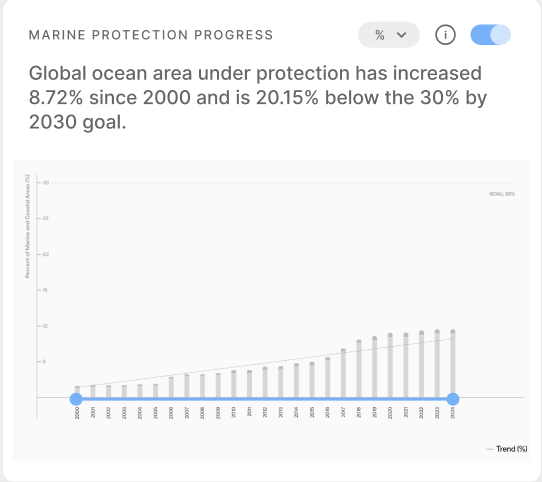

### Fig 2

The areas in km2 for MPAs and OECM protection for November, 2025 is derived from [Protected Planet](https://www.protectedplanet.net/en/thematic-areas/marine-protected-areas) and it is 35744174 km2. Out of that, MPA coverage is 34882869.49 km2 whereas OECM coverage is 861304.51 km2. The total MPAs coverage of protected areas is 34882869.49/35744174 * 100 which is 97.59% whereas the remaining is OECM %.

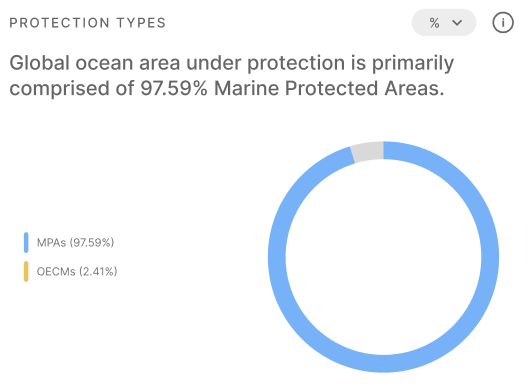

### Fig 3

In [ ]:
# This file is provided by Protected Planet. MPA and OECM polygons are merged into one layer using QGIS and rasterized for ease of display.
# For rasterization, we use the function in utils
vector_to_raster(
    vector_path='mpas_oecms_merged.gpkg', #change paths accordingly
    out_raster_path='mpas_oecms_extent.tif',
    pixel_size_m=5000,
    attribute=None,
    target_crs="EPSG:3857" # chosen for ease of rasterization - the final tif is reprojected to EPSG:4326 above
)

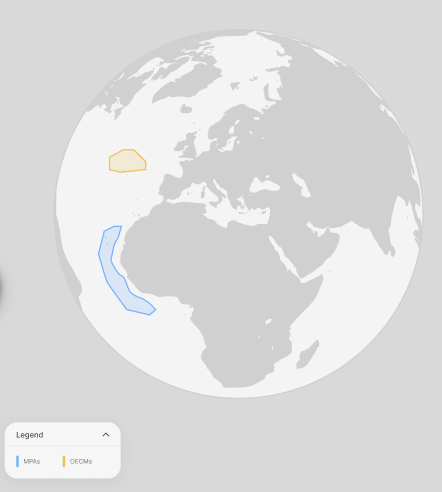

### Fig 4

This number is obtained as is from Protected Planet's statistics for the latest MPA + OECMs file.

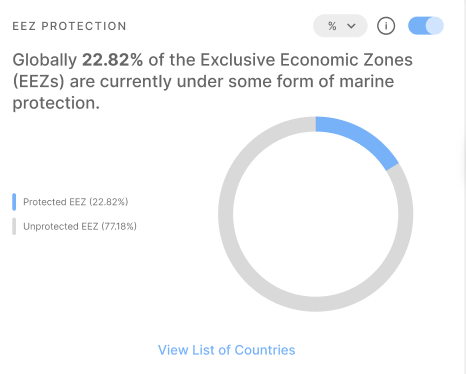

### Fig 8

There are two ways to do the intersection between EEZs and MPAs.

The first is using QGIS. 
1. Load both layers into QGIS: add the EEZ polygon layer and the MPA polygon layer.
2. (Optional) Run Vector → Geometry → Fix Geometries on each layer to clean any geometry errors.
3. Open Vector → Geoprocessing Tools → Intersection from the top menu.
4. Set Input layer to EEZ and Overlay layer to MPA in the Intersection dialog.
5. Choose an output file location and format (e.g., GeoJSON or Shapefile) for the intersection result.
6. Click Run to create a new layer showing only the areas where EEZ and MPA overlap.
7. Open the attribute table of the intersection layer and, if needed, use the Field Calculator to add an area or area_km2 field for area analysis.

In [ ]:
# A second option is using python - specifically the intersection function defined in utils above

ecosystem_path = "EEZ_v12.shp"   # or .gpkg / .geojson
mpa_oecm_path       = "wdpa_mpa_oecm_merged.gpkg"        # or .shp / .geojson

# Where to save the intersection (optional)
out_intersection = "outputs/Fig_8_eez_mpa_oecm_intersection.geojson"

# Run intersection
eez_mpa_intersection = intersect_ecosystem_with_mpa(
    ecosystem_path=ecosystem_path,
    mpa_path=mpa_oecm_path,
    out_intersection=out_intersection
)

# Convert the output vector into a raster for ease of display
vector_to_raster(
    vector_path='Fig_8_eez_mpa_oecm_intersection.geojson', #change paths accordingly
    out_raster_path='Fig_8_eez_mpa_oecm_intersection.tif',
    pixel_size_m=5000,
    attribute=None,
    target_crs="EPSG:3857" # chosen for ease of rasterization - the final tif is reprojected to EPSG:4326 above
)

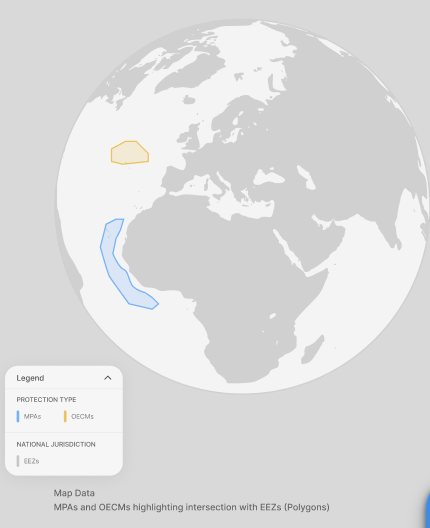

### Fig 5 and Fig 9

This data for Fig 5 was obtained from the [Marine Protection Atlas's MPA Guide](https://mpatlas.org/mpaguide/). 

The file of MPAs by protection levels was downloaded from Marine Protection Atlas for Fig 9. 

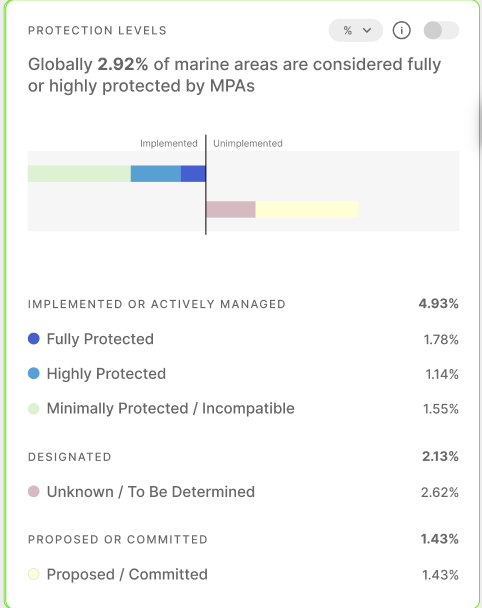

### Fig 6 and 10

These are heavy ecosystem datasets which is why QGIS was a better choice for % intersections.

1. For those polygons with incorrect geometries, the geometries were corrected using Vector → Geometry → Fix Geometries.
2. The merged file of Marine Protected Areas (MPAs) and OECMs were dissolved into a single polygon to remove double counting due to overlaps.
3. Each ecosystem layer was also dissolved into a single polygon to avoid double counting within the ecosystem extent.
4. For both the dissolved MPA and OECMs layer and each dissolved ecosystem layer, an area field was created in the attribute table using the Field Calculator with the formula of in `$area` an equal-area projected CRS.
5. The intersection was taken between the dissolved MPA + OECM polygon and each dissolved ecosystem polygon using the Intersection geoprocessing tool.
6. The area of each intersection was also calculated with '$area' in the Field Calculator, in the same equal-area CRS.

Finally, the percentage protected for each ecosystem was computed as: area of the intersection divided by the total area of the ecosystem to get the % protected.

The intersection vectors were saved as geojsons and converted to rasters using the vector_to_raster function above.

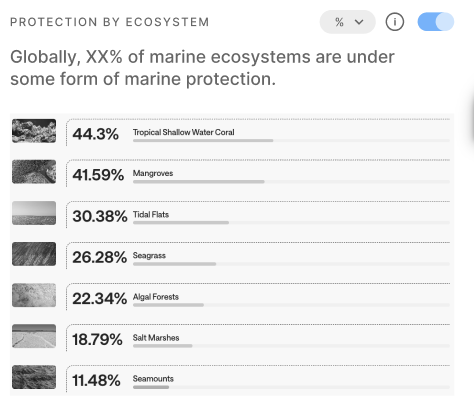

### Fig 7 and Fig 11

For the intersection of critical marine ecosystems and MPA + OECMs, the merged vector file of protected areas was intersected with the raster and the intersection was dissolved for calculating the area.

In [ ]:
# Defining a function for intersecting a vector file with a raster and getting the area percentage along with the intersection file

def raster_vector_intersection_stats(
    raster_path: str,
    vector_path: str,
    vector_layer: str | None = None,
    out_raster_union: str | None = "raster_gt0_union.geojson",
    out_intersection: str | None = "raster_vector_intersection.geojson",
    area_crs: str = "ESRI:54009",
):
    """
    Compute intersection between a raster mask (values > 0) and a vector layer,
    and print areas + percentage.

    Parameters
    ----------
    raster_path : str
        Path to the raster file.
    vector_path : str
        Path to the vector file (e.g. shapefile, GeoPackage, GeoJSON).
    vector_layer : str or None, optional
        Layer name for multi-layer formats (e.g. GeoPackage). If None,
        uses the default layer for the file.
    out_raster_union : str or None, optional
        Output path for the union of raster>0 polygons (GeoJSON). If None, not saved.
    out_intersection : str or None, optional
        Output path for the intersection polygons (GeoJSON). If None, not saved.
    area_crs : str, optional
        Equal-area CRS used to compute areas (default: ESRI:54009, Mollweide).

    Returns
    -------
    result : geopandas.GeoDataFrame
        Intersection GeoDataFrame.
    stats : dict
        Dictionary with 'raster_area', 'vector_area', 'percentage'.
    """

    # -------------------------------------------------------------------
    # 1. Read polygons
    # -------------------------------------------------------------------
    if vector_layer:
        poly_gdf = gpd.read_file(vector_path, layer=vector_layer)
    else:
        poly_gdf = gpd.read_file(vector_path)
    print("Polygons read")

    # -------------------------------------------------------------------
    # 2. Build polygons from raster cells where raster > 0
    # -------------------------------------------------------------------
    with rasterio.open(raster_path) as src:
        data = src.read(1)
        transform = src.transform
        nodata = src.nodata
        raster_crs = src.crs

        # mask = True where raster value > 0
        mask = data > 0
        if nodata is not None:
            mask &= (data != nodata)

        # Extract raster>0 regions as polygons
        raster_geoms = []
        for geom, val in shapes(data, mask=mask, transform=transform):
            # val is the raster value; we only care about geometry
            raster_geoms.append(shape(geom))

    print("Raster polygons created")

    # Merge all raster>0 polygons into one
    raster_union = gpd.GeoSeries(raster_geoms, crs=raster_crs).unary_union
    raster_union_gdf = gpd.GeoDataFrame(geometry=[raster_union], crs=raster_crs)

    # Optional: save union polygon
    if out_raster_union is not None:
        raster_union_gdf.to_file(out_raster_union, driver="GeoJSON")
        print(f"Saved raster>0 union to {out_raster_union}")

    # -------------------------------------------------------------------
    # 3. Reproject polygons if needed
    # -------------------------------------------------------------------
    if poly_gdf.crs != raster_union_gdf.crs:
        poly_gdf = poly_gdf.to_crs(raster_union_gdf.crs)
        print(f"Reprojected vectors to {raster_union_gdf.crs}")

    # -------------------------------------------------------------------
    # 4. Intersect polygons with raster>0 area
    # -------------------------------------------------------------------
    result = gpd.overlay(poly_gdf, raster_union_gdf, how="intersection")

    # Save intersection (optional)
    if out_intersection is not None:
        result.to_file(out_intersection, driver="GPKG")
        print(f"Saved intersection to {out_intersection}")

    print(result.head())

    # -------------------------------------------------------------------
    # 5. Area calculations in equal-area CRS
    # -------------------------------------------------------------------
    # Raster mask area (>0) in equal-area CRS
    raster_union_moll = raster_union_gdf.to_crs(area_crs)
    raster_area = raster_union_moll.geometry.area.iloc[0]

    # Dissolve intersection into one polygon and compute area in equal-area CRS
    vector_diss = result.dissolve()
    vector_diss_moll = vector_diss.to_crs(area_crs)
    vector_area = vector_diss_moll.geometry.area.iloc[0]

    percentage = (vector_area / raster_area) * 100 if raster_area != 0 else float("nan")

    # Print stats
    print(f"Raster mask area (>0): {raster_area:,.2f} (in {area_crs})")
    print(f"Total dissolved vector area: {vector_area:,.2f} (in {area_crs})")
    print(f"Percentage of vector area over raster area: {percentage:.2f}%")

    stats = {
        "raster_area": float(raster_area),
        "vector_area": float(vector_area),
        "percentage": float(percentage),
    }

    return result, stats

# The stats will be used directly for Fig 7
# Apply the raster_vector_intersection_stats function to the critical_ecosystems tif and the MPA + OECMs file
raster_path = "masked_top_30_percent_over_water.tif"             # ← replace with your .tif
vector_path = "merged_mpa_oecms.shp"             # ← replace with your shapefile
output_union = "masked_top_30_percent_over_water_union.geojson"
output_intersection = "merged_mpas_oecms_critical_ecosystems.geojson"

result_gdf, stats = raster_vector_intersection_stats(
    raster_path=raster_path,
    vector_path=vector_path,
    vector_layer=None,                       # set if using a GeoPackage with multiple layers
    out_raster_union=output_union,
    out_intersection=output_intersection,
    area_crs="ESRI:54009"
)

# Once you get the intersection vector file, you can convert it into a raster
vector_to_raster(
    vector_path='merged_mpas_oecms_critical_ecosystems.geojson', #change paths accordingly
    out_raster_path='Fig_11_merged_mpas_oecms_critical_ecosystems.tif',
    pixel_size_m=5000,
    attribute=None,
    target_crs="EPSG:3857" # chosen for ease of rasterization - the final tif is reprojected to EPSG:4326 above
)

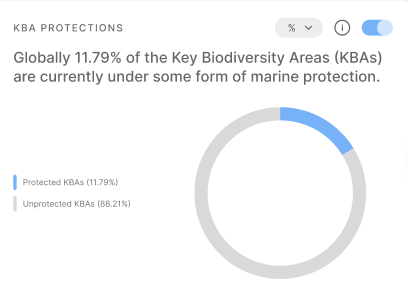

## MPAs

### Fig 1

Please refer to the code in Fig 1 of 'All Types' for this figure. The same function and code will be used.

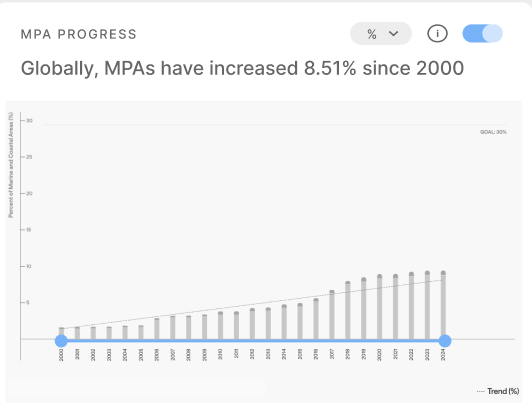

### Fig 2

In [ ]:
# This file is provided by Protected Planet. MPA and OECM polygons are merged into one layer using QGIS and rasterized for ease of display.
# For rasterization, we use the function in utils
vector_to_raster(
    vector_path='mpas_merged.gpkg', #change paths accordingly
    out_raster_path='Fig_2_mpas_extent.tif',
    pixel_size_m=5000,
    attribute=None,
    target_crs="EPSG:3857" # chosen for ease of rasterization - the final tif is reprojected to EPSG:4326 above
)

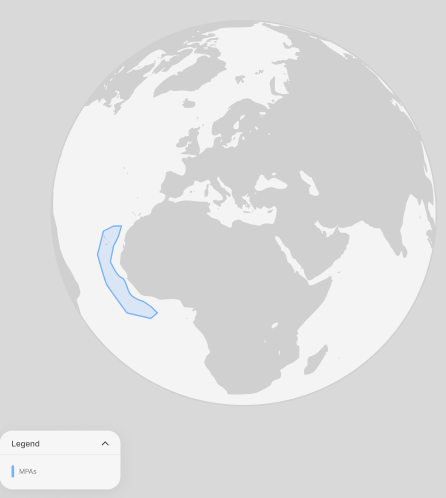

### Fig 3

This number is obtained as is from Protected Planet's statistics for the latest MPA + OECMs file.

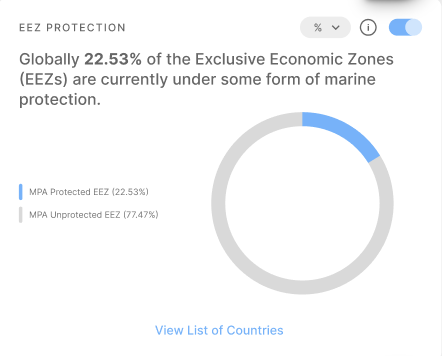

### Fig 7

There are two ways to do the intersection between EEZs and MPAs.

The first is using QGIS. 
1. Load both layers into QGIS: add the EEZ polygon layer and the MPA polygon layer.
2. (Optional) Run Vector → Geometry → Fix Geometries on each layer to clean any geometry errors.
3. Open Vector → Geoprocessing Tools → Intersection from the top menu.
4. Set Input layer to EEZ and Overlay layer to MPA in the Intersection dialog.
5. Choose an output file location and format (e.g., GeoJSON or Shapefile) for the intersection result.
6. Click Run to create a new layer showing only the areas where EEZ and MPA overlap.
7. Open the attribute table of the intersection layer and, if needed, use the Field Calculator to add an area or area_km2 field for area analysis.

In [ ]:
# A second option is using python - specifically the intersection function defined in utils above

ecosystem_path = "EEZ_v12.shp"   # or .gpkg / .geojson
mpa_path       = "wdpa_mpa_merged.gpkg"        # or .shp / .geojson

# Where to save the intersection (optional)
out_intersection = "outputs/Fig_7_eez_mpa_intersection.geojson"

# Run intersection
eez_mpa_intersection = intersect_ecosystem_with_mpa(
    ecosystem_path=ecosystem_path,
    mpa_path=mpa_path,
    out_intersection=out_intersection
)

# Inspect result
print(eez_mpa_intersection.head())

# Convert the output vector into a raster for ease of display
vector_to_raster(
    vector_path='Fig_7_eez_mpa_intersection.geojson', #change paths accordingly
    out_raster_path='Fig_7_eez_mpa_intersection.tif',
    pixel_size_m=5000,
    attribute=None,
    target_crs="EPSG:3857" # chosen for ease of rasterization - the final tif is reprojected to EPSG:4326 above
)

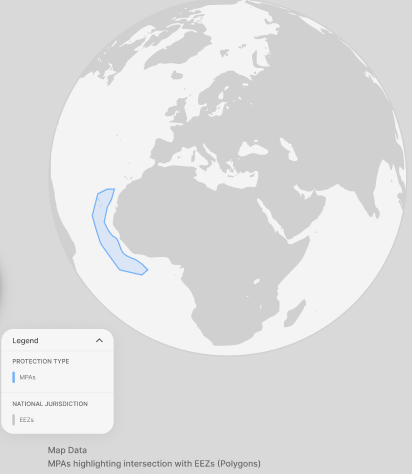

### Fig 4 and Fig 8

Same figures as Fig 5 and Fig 9 in the All Types section. 
This data for Fig 4 was obtained from the Marine Protection Atlas's MPA Guide.

The file of MPAs by protection levels was downloaded from Marine Protection Atlas for Fig 8.

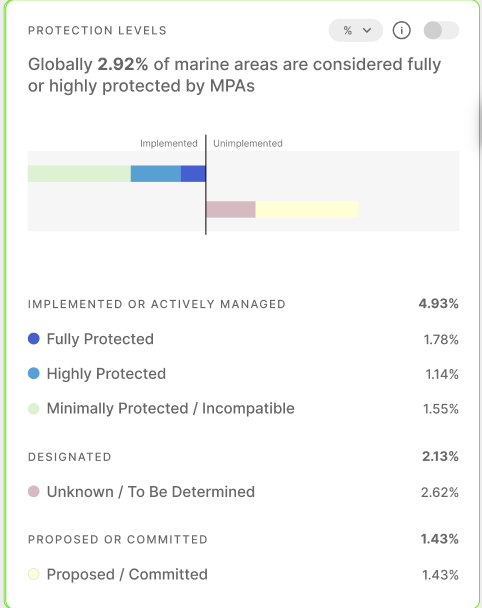

### Fig 5 and 9

These are heavy ecosystem datasets which is why QGIS was a better choice for % intersections.

1. For those polygons with incorrect geometries, the geometries were corrected using Vector → Geometry → Fix Geometries.
2. Marine Protected Areas (MPAs) were dissolved into a single polygon to remove double counting due to overlaps.
3. Each ecosystem layer was also dissolved into a single polygon to avoid double counting within the ecosystem extent.
4. For both the dissolved MPA layer and each dissolved ecosystem layer, an area field was created in the attribute table using the Field Calculator with the expression`$area`(in an equal-area projected CRS).
6. The intersection was taken between the dissolved MPA polygon and each dissolved ecosystem polygon using the Intersection geoprocessing tool.
7. The area of each intersection was also calculated with $area in the Field Calculator, in the same equal-area CRS.

Finally, the percentage protected for each ecosystem was computed as: area of the intersection divided by the total area of the ecosystem to get the % protected.

The intersection vectors were saved as geojsons and converted to rasters using the vector_to_raster function above.

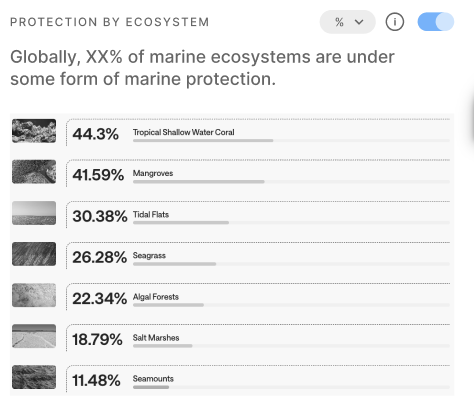

### Fig 6 and Fig 10

In [ ]:
# The same process as the KBA intersection of All Types is followed
# The only difference is the vector file being intersected is ONLY MPAs instead of MPAs + OECMs

# Apply the raster_vector_intersection_stats function to the critical_ecosystems tif and the MPA + OECMs file
raster_path = "masked_top_30_percent_over_water.tif"             # ← replace with your .tif
vector_path = "merged_mpas.shp"             # ← replace with your shapefile
output_union = "masked_top_30_percent_over_water_union.geojson"
output_intersection = "merged_mpas_critical_ecosystems.geojson"

result_gdf, stats = raster_vector_intersection_stats(
    raster_path=raster_path,
    vector_path=vector_path,
    vector_layer=None,                       # set if using a GeoPackage with multiple layers
    out_raster_union=output_union,
    out_intersection=output_intersection,
    area_crs="ESRI:54009"
)

# Once you get the intersection vector file, you can convert it into a raster
vector_to_raster(
    vector_path='merged_mpas_critical_ecosystems.geojson', #change paths accordingly
    out_raster_path='Fig_11_merged_mpas_critical_ecosystems.tif',
    pixel_size_m=5000,
    attribute=None,
    target_crs="EPSG:3857" # chosen for ease of rasterization - the final tif is reprojected to EPSG:4326 above
)

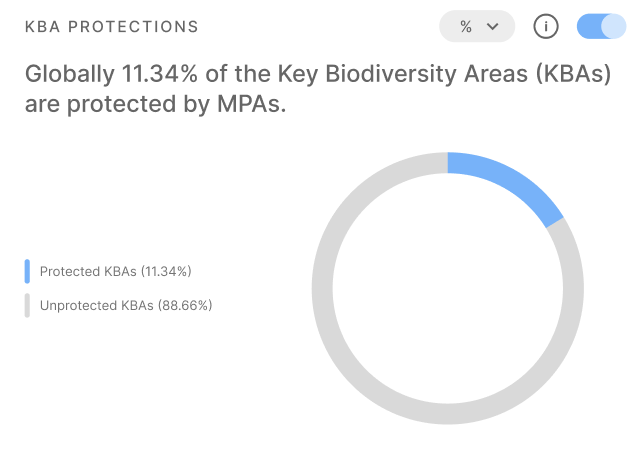

## OECMs

### Fig 1

Please refer to the code in Fig 1 of 'All Types' for this figure. The same function and code will be used.

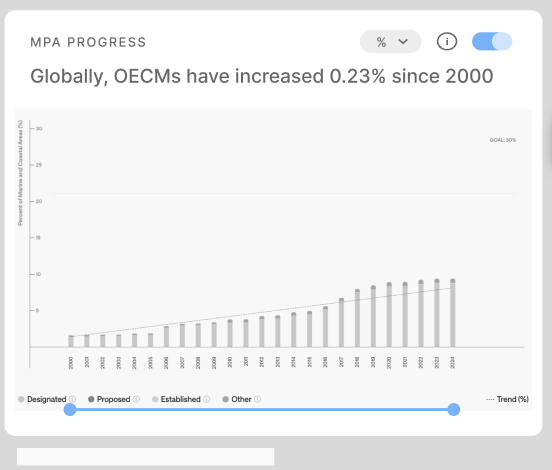

### Fig 2

This dataset is provided by Protected Planet as is.

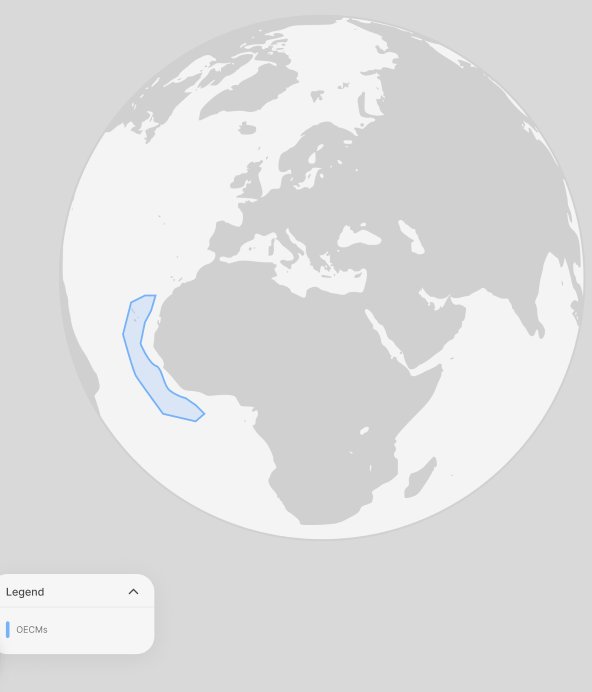

### Fig 3

This number is obtained as is from Protected Planet's statistics for the latest MPA + OECMs file.

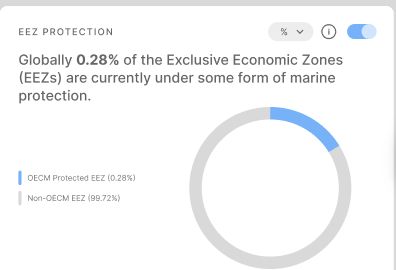

### Fig 6

In [ ]:
ecosystem_path = "EEZ_v12.shp"   # or .gpkg / .geojson
mpa_path       = "wdpa_oecm_merged.gpkg"        # or .shp / .geojson

# Where to save the intersection (optional)
out_intersection = "outputs/Fig_6_eez_oecm_intersection.geojson"

# Run intersection
eez_oecm_intersection = intersect_ecosystem_with_mpa(
    ecosystem_path=ecosystem_path,
    mpa_path=mpa_path,
    out_intersection=out_intersection
)

# Inspect result
print(eez_oecm_intersection.head())

# Convert the output vector into a raster for ease of display
vector_to_raster(
    vector_path='Fig_6_eez_oecm_intersection.geojson', #change paths accordingly
    out_raster_path='Fig_6_eez_oecm_intersection.tif',
    pixel_size_m=5000,
    attribute=None,
    target_crs="EPSG:3857" # chosen for ease of rasterization - the final tif is reprojected to EPSG:4326 above
)

### Fig 4 and 7

These are heavy ecosystem datasets which is why QGIS was a better choice for % intersections.

1. For those polygons with incorrect geometries, the geometries were corrected using Vector → Geometry → Fix Geometries.
2. OECMs were dissolved into a single polygon to remove double counting due to overlaps.
3. Each ecosystem layer was also dissolved into a single polygon to avoid double counting within the ecosystem extent.
4. For both the dissolved OECMs layer and each dissolved ecosystem layer, an area field was created in the attribute table using the Field Calculator with the expression`$area`(in an equal-area projected CRS).
6. The intersection was taken between the dissolved OECM polygon and each dissolved ecosystem polygon using the Intersection geoprocessing tool.
7. The area of each intersection was also calculated with $area in the Field Calculator, in the same equal-area CRS.

Finally, the percentage protected for each ecosystem was computed as: area of the intersection divided by the total area of the ecosystem to get the % protected.

The intersection vectors were saved as geojsons and converted to rasters using the vector_to_raster function above.

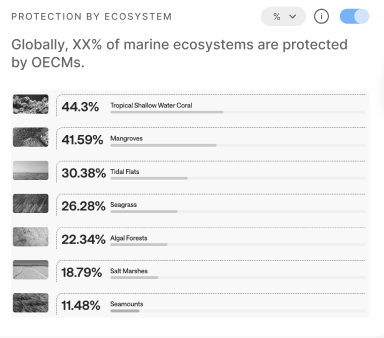

### Fig 5 and 8

In [ ]:
# The same process as the KBA intersection of All Types is followed
# The only difference is the vector file being intersected is ONLY OECMs instead of MPAs + OECMs

# Apply the raster_vector_intersection_stats function to the critical_ecosystems tif and the MPA + OECMs file
raster_path = "masked_top_30_percent_over_water.tif"             # ← replace with your .tif
vector_path = "merged_oecms.shp"             # ← replace with your shapefile
output_union = "masked_top_30_percent_over_water_union.geojson"
output_intersection = "merged_oecms_critical_ecosystems.geojson"

result_gdf, stats = raster_vector_intersection_stats(
    raster_path=raster_path,
    vector_path=vector_path,
    vector_layer=None,                       # set if using a GeoPackage with multiple layers
    out_raster_union=output_union,
    out_intersection=output_intersection,
    area_crs="ESRI:54009"
)

# Once you get the intersection vector file, you can convert it into a raster
vector_to_raster(
    vector_path='merged_oecms_critical_ecosystems.geojson', #change paths accordingly
    out_raster_path='Fig_11_merged_oecms_critical_ecosystems.tif',
    pixel_size_m=5000,
    attribute=None,
    target_crs="EPSG:3857" # chosen for ease of rasterization - the final tif is reprojected to EPSG:4326 above
)

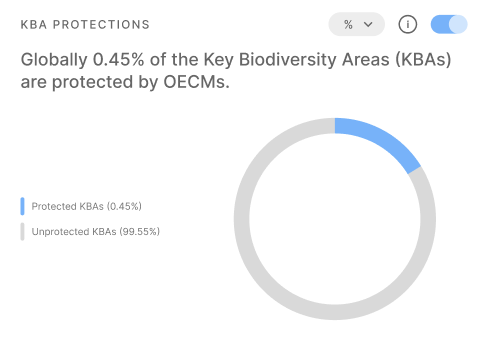